In [1]:
%load_ext autoreload
%autoreload 2
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=2

import sys, os
sys.path.insert(0, '..')
from lib import graph, coarsening, utils

import torch
import numpy as np
import scipy.sparse
import matplotlib.pyplot as plt
import time

# print(torch.cuda.device_count())
# torch.cuda.set_device(2)

%matplotlib inline

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=2


# Arguments and Graph

In [20]:
%reload_ext autoreload
import argparse
%xmode
sys.argv=['']
parser = argparse.ArgumentParser(description='Implementation of Graph CNN for 20news pytorch version')
# Graphs.
parser.add_argument('--number_edges', type=int, default=16,
                    help='Graph: minimum number of edges per vertex. default=8')
# TODO: change cgcnn for combinatorial Laplacians.
parser.add_argument('--metric', type=str, default='cosine', 
                    help='Graph: similarity measure (between features). default=cosine')
parser.add_argument('--normalized_laplacian', type=bool, default=True, 
                    help='Graph Laplacian: normalized. default=True')
parser.add_argument('--coarsening_levels', type=int, default=0, 
                    help='Number of coarsened graphs. default=4')
# Directories.
parser.add_argument('--dir_data', type=str, default=os.path.join('..', 'data', '20news'), 
                    help='Directory to store data. default=os.path.join(\'..\', \'data\', \'mnist\')')

parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='No. of batches to wait before logging training status')

parser.add_argument('--cuda', type=bool, default=True,
                   help='Run on GPU or not. default=True')

args = parser.parse_args()


Exception reporting mode: Plain


# Data

In [3]:
from torchvision import datasets, transforms
from torch.autograd import Variable

# Fetch dataset. Scikit-learn already performs some cleaning.
remove = ('headers','footers','quotes')  # (), ('headers') or ('headers','footers','quotes')
train = utils.Text20News(data_home=args.dir_data, subset='train', remove=remove)

# Pre-processing: transform everything to a-z and whitespace.
print(train.show_document(1)[:400])
train.clean_text(num='substitute')

# Analyzing / tokenizing: transform documents to bags-of-words.
#stop_words = set(sklearn.feature_extraction.text.ENGLISH_STOP_WORDS)
# Or stop words from NLTK.
# Add e.g. don, ve.
train.vectorize(stop_words='english')
print(train.show_document(1)[:400])



N = 11314 documents, C = 20 classes
document 1: label 4 --> comp.sys.mac.hardware, 90 words
A fair number of brave souls who upgraded their SI clock oscillator have
shared their experiences for this poll. Please send a brief message detailing
your experiences with the procedure. Top speed attained, CPU rated speed,
add on cards and adapters, heat sinks, hour of usage per day, floppy disk
functionality with 800 and 1.4 m floppies are especially requested.

I will be summarizing in the nex
document 1: label 4 --> comp.sys.mac.hardware, 92 words
  1.00 "adapters" (669)
  2.00 "add" (684)
  1.00 "answered" (2523)
  1.00 "attained" (3941)
  1.00 "base" (5026)
  1.00 "brave" (7179)
  1.00 "brief" (7318)
  1.00 "cards" (8579)
  2.00 "clock" (10473)
  1.00 "cpu" (12728)
  1.00 "day" (14053)
  1.00 "days" (14068)
  1.00 "detailing" (15215)
  1.00 "disk" (16087)
  1.00 "especially" (19550)
  2.00 "experiences" (20279)
  1.00 "fair" (20691)
  1.00 "floppies" (22013)
  1.00 "floppy" (22014)
  1.00

N = 11314 documents, M = 72607 words, sparsity=0.0852%
    480 documents in class  0 (alt.atheism)
    584 documents in class  1 (comp.graphics)
    591 documents in class  2 (comp.os.ms-windows.misc)
    590 documents in class  3 (comp.sys.ibm.pc.hardware)
    578 documents in class  4 (comp.sys.mac.hardware)
    593 documents in class  5 (comp.windows.x)
    585 documents in class  6 (misc.forsale)
    594 documents in class  7 (rec.autos)
    598 documents in class  8 (rec.motorcycles)
    597 documents in class  9 (rec.sport.baseball)
    600 documents in class 10 (rec.sport.hockey)
    595 documents in class 11 (sci.crypt)
    591 documents in class 12 (sci.electronics)
    594 documents in class 13 (sci.med)
    593 documents in class 14 (sci.space)
    599 documents in class 15 (soc.religion.christian)
    546 documents in class 16 (talk.politics.guns)
    564 documents in class 17 (talk.politics.mideast)
    465 documents in class 18 (talk.politics.misc)
    377 documents in cl

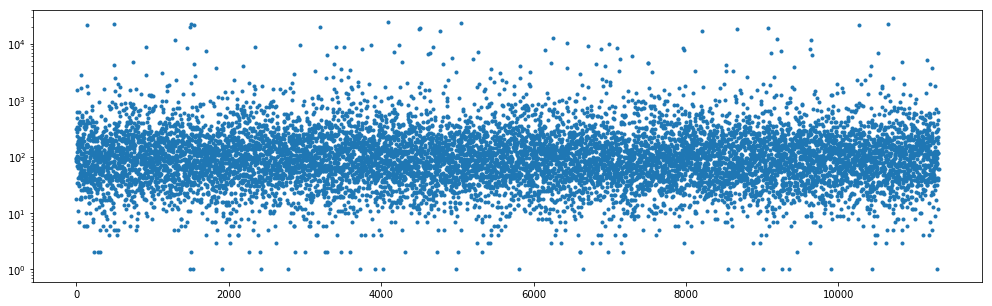

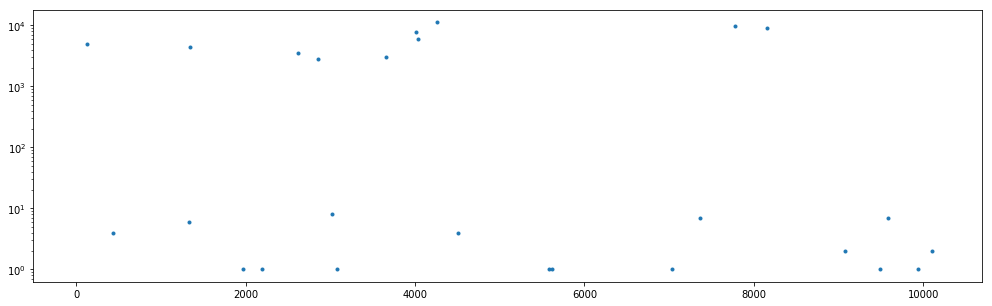

In [4]:
train.data_info(True)
wc = train.remove_short_documents(nwords=20, vocab='full')
train.data_info()
print('shortest: {}, longest: {} words'.format(wc.min(), wc.max()))
plt.figure(figsize=(17,5))
plt.semilogy(wc, '.');

# Remove encoded images.
def remove_encoded_images(dataset, freq=1e3):
    widx = train.vocab.index('ax')
    wc = train.data[:,widx].toarray().squeeze()
    idx = np.argwhere(wc < freq).squeeze()
    dataset.keep_documents(idx)
    return wc
wc = remove_encoded_images(train)
train.data_info()
plt.figure(figsize=(17,5))
plt.semilogy(wc, '.');

In [5]:
# Word embedding
if True:
    train.embed()
else:
    train.embed(os.path.join('..', 'data', 'word2vec', 'GoogleNews-vectors-negative300.bin'))
train.data_info()
# Further feature selection. (TODO)

53279 words not found in corpus
N = 10171 documents, M = 19328 words, sparsity=0.3141%


most frequent words
    0: num        163934 counts
    1: dollar      10562 counts
    2: people       4093 counts
    3: like         3942 counts
    4: don          3869 counts
    5: just         3721 counts
    6: know         3464 counts
    7: use          3166 counts
    8: think        2995 counts
    9: time         2966 counts
   10: does         2749 counts
   11: new          2606 counts
   12: good         2492 counts
   13: edu          2416 counts
   14: way          2032 counts
   15: make         2022 counts
   16: god          1976 counts
   17: used         1874 counts
   18: ve           1857 counts
   19: say          1841 counts
N = 10171 documents, M = 1000 words, sparsity=2.8353%
document 1: label 4 --> comp.sys.mac.hardware, 92 words
  3.00 "num" (0)
  1.00 "number" (40)
  1.00 "thanks" (48)
  1.00 "day" (76)
  1.00 "send" (97)
  1.00 "disk" (157)
  1.00 "message" (206)
  2.00 "speed" (226)
  1.00 "days" (244)
  1.00 "especially" (383)
  2.00 "add" (443)
  1.0

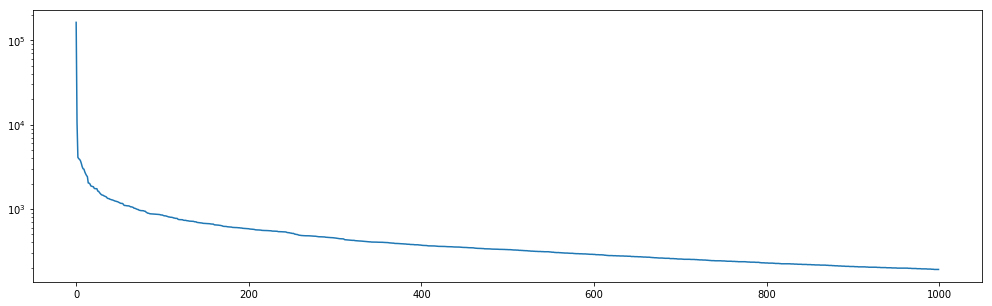

In [6]:
# Feature selection.
# Other options include: mutual information or document count.
freq = train.keep_top_words(1000, 20)
train.data_info()
train.show_document(1)
plt.figure(figsize=(17,5))
plt.semilogy(freq);

# Remove documents whose signal would be the zero vector.
wc = train.remove_short_documents(nwords=5, vocab='selected')
train.data_info(True)

In [7]:
train.normalize(norm='l1')
train.show_document(1);

document 1: label 4 --> comp.sys.mac.hardware, 92 words
  0.13 "num" (0)
  0.04 "number" (40)
  0.04 "thanks" (48)
  0.04 "day" (76)
  0.04 "send" (97)
  0.04 "disk" (157)
  0.04 "message" (206)
  0.09 "speed" (226)
  0.04 "days" (244)
  0.04 "especially" (383)
  0.09 "add" (443)
  0.04 "haven" (467)
  0.04 "network" (529)
  0.04 "cards" (591)
  0.04 "knowledge" (614)
  0.04 "base" (708)
  0.04 "floppy" (758)
  0.09 "clock" (977)


In [8]:
# Test dataset.
test = utils.Text20News(data_home=args.dir_data, subset='test', remove=remove)
test.clean_text(num='substitute')
test.vectorize(vocabulary=train.vocab)
test.data_info()
wc = test.remove_short_documents(nwords=5, vocab='selected')
print('shortest: {}, longest: {} words'.format(wc.min(), wc.max()))
test.data_info(True)
test.normalize(norm='l1')

N = 7532 documents, C = 20 classes
N = 7532 documents, M = 1000 words, sparsity=2.4662%
shortest: 0, longest: 23751 words
N = 6695 documents, M = 1000 words, sparsity=2.7528%
    275 documents in class  0 (alt.atheism)
    355 documents in class  1 (comp.graphics)
    358 documents in class  2 (comp.os.ms-windows.misc)
    370 documents in class  3 (comp.sys.ibm.pc.hardware)
    348 documents in class  4 (comp.sys.mac.hardware)
    365 documents in class  5 (comp.windows.x)
    359 documents in class  6 (misc.forsale)
    336 documents in class  7 (rec.autos)
    321 documents in class  8 (rec.motorcycles)
    345 documents in class  9 (rec.sport.baseball)
    350 documents in class 10 (rec.sport.hockey)
    344 documents in class 11 (sci.crypt)
    362 documents in class 12 (sci.electronics)
    345 documents in class 13 (sci.med)
    346 documents in class 14 (sci.space)
    365 documents in class 15 (soc.religion.christian)
    319 documents in class 16 (talk.politics.guns)
    338 

In [9]:
if True:
    train_data = train.data.astype(np.float32)
    test_data = test.data.astype(np.float32)
    train_labels = train.labels
    test_labels = test.labels
else:
    perm = np.random.RandomState(seed=42).permutation(dataset.data.shape[0])
    Ntest = 6695
    perm_test = perm[:Ntest]
    perm_train = perm[Ntest:]
    train_data = train.data[perm_train,:].astype(np.float32)
    test_data = train.data[perm_test,:].astype(np.float32)
    train_labels = train.labels[perm_train]
    test_labels = train.labels[perm_test]

if True:
    graph_data = train.embeddings.astype(np.float32)
else:
    graph_data = train.data.T.astype(np.float32).toarray()

#del train, test

# Feature graph

In [10]:
t_start = time.process_time()
dist, idx = graph.distance_sklearn_metrics(graph_data, k=args.number_edges, metric=args.metric)
A = graph.adjacency(dist, idx)
print("{} > {} edges".format(A.nnz//2, args.number_edges*graph_data.shape[0]//2))
A = graph.replace_random_edges(A, 0)
graphs, perm = coarsening.coarsen(A, levels=args.coarsening_levels, self_connections=False)
L = [graph.laplacian(A, normalized=True) for A in graphs]
print('Execution time: {:.2f}s'.format(time.process_time() - t_start))
#graph.plot_spectrum(L)
#del graph_data, A, dist, idx

11354 > 8000 edges
Layer 0: M_0 = |V| = 1000 nodes (0 added),|E| = 11354 edges
Execution time: 0.65s


In [11]:
t_start = time.process_time()
train_data = scipy.sparse.csr_matrix(coarsening.perm_data(train_data.toarray(), perm))
test_data = scipy.sparse.csr_matrix(coarsening.perm_data(test_data.toarray(), perm))
print('Execution time: {:.2f}s'.format(time.process_time() - t_start))
del perm

Execution time: 0.21s


In [12]:
val_data = test_data
val_labels = test_labels
utils.baseline(train_data, train_labels, test_data, test_labels)

/home/yimin/.pyenv/versions/3.6.3/envs/pyt0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Train accuracy:      46.08 55.27 64.24 99.06 71.39 69.77 73.51
Test accuracy:       28.95 46.90 48.99 50.04 54.80 56.39 57.15
Train F1 (weighted): 46.34 53.35 64.96 99.06 69.93 68.98 72.86
Test F1 (weighted):  28.54 44.72 49.45 49.42 52.50 55.02 56.03
Execution time:       4.90  0.78  0.03  1.48  0.02  1.16  0.85


In [14]:
from torch.utils.data import TensorDataset, DataLoader
kwargs ={'num_workers': 1, 'pin_memory': True} if args.cuda else {}

def cus_dataset(L):
    L = L.tocoo()
    indices = torch.from_numpy(np.column_stack((L.row, L.col))).long()
    L = torch.sparse.DoubleTensor(indices.t(), 
                                  torch.from_numpy(L.data).double(), 
                                  torch.Size(list(L.shape)))
    return L.to_dense()

trainset = TensorDataset(cus_dataset(train_data), torch.from_numpy(train_labels))
testset = TensorDataset(cus_dataset(test_data), torch.from_numpy(test_labels))
train_loader = DataLoader(trainset, batch_size=100, shuffle=True, **kwargs)
test_loader = DataLoader(testset, batch_size=1000, shuffle=True, **kwargs)

# Model init

In [41]:
from model_pytorch import CGCNN_Net

common = {}
common['dir_name']       = '20news/'
common['num_epochs']     = 80
common['batch_size']     = 100
common['decay_steps']    = len(train_labels) / common['batch_size']
common['eval_frequency'] = 5 * common['num_epochs']
common['filter']         = 'chebyshev5'
common['bias']           = 'bias1'
common['pool']           = 'maxpool'
C = max(train_labels) + 1  # number of classes

name = 'cgconv_fc_softmax'
common['dir_name'] += name
common['regularization'] = 0
common['dropout']        = 0
common['learning_rate']  = 0.1
common['decay_rate']     = 0.001
common['momentum']       = 0
common['F']              = [5]
common['K']              = [15]
common['p']              = [1]
common['M']              = [L[-1].shape[0], 100, int(C)]

model = CGCNN_Net(L, **common)
model.double().cuda()

CGCNN_Net(
  (linear_chebyshev): ModuleList(
    (0): Linear(in_features=15, out_features=5)
  )
  (fc_hidden): Linear(in_features=5000, out_features=100)
  (fc_output): Linear(in_features=100, out_features=20)
)

# Training and Test

In [42]:
from torch.autograd import Variable
from torch.nn import functional as F
from tensorboardX import SummaryWriter

writer = SummaryWriter()
optimizer = torch.optim.SGD(model.parameters(), 
                            lr=model.learning_rate, 
                            momentum=model.momentum,
                            weight_decay=model.decay_rate)

def train(epoch):
    model.train()
    t_process, t_wall = time.process_time(), time.time()
    loader_len = len(train_loader)
    for batch_idx, (data, target) in enumerate(train_loader):
        n_iter = (epoch * loader_len) + batch_idx
        data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        data = data.unsqueeze(1)
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        writer.add_scalar('Loss', loss.data[0], n_iter)
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, min((batch_idx+10)*len(data),len(train_loader.dataset)), 
                len(train_loader.dataset),
                100. * (batch_idx+10) / loader_len, loss.data[0])) 

def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    dataset_len = len(test_loader.dataset)
    for data, target in test_loader:
        data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        data = data.unsqueeze(1)
        output = model(data)
        # sum up batch loss
        test_loss += F.cross_entropy(output, target, size_average=False).data[0]
        # get the index of the max log-probability
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= dataset_len
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, dataset_len, 100. * correct / dataset_len))
    writer.add_scalar('Accuracy', 100. * correct / dataset_len, epoch)
for epoch in range(1, 80 + 1):
    train(epoch)
    test(epoch)

writer.close()

Train Epoch: 1 [1000/9922 (10%)]	Loss: 2.999789
Train Epoch: 1 [2000/9922 (20%)]	Loss: 2.997617
Train Epoch: 1 [3000/9922 (30%)]	Loss: 3.009771
Train Epoch: 1 [4000/9922 (40%)]	Loss: 3.000249
Train Epoch: 1 [5000/9922 (50%)]	Loss: 2.994733
Train Epoch: 1 [6000/9922 (60%)]	Loss: 2.996499
Train Epoch: 1 [7000/9922 (70%)]	Loss: 3.009748
Train Epoch: 1 [8000/9922 (80%)]	Loss: 2.998866
Train Epoch: 1 [9000/9922 (90%)]	Loss: 2.988388
Train Epoch: 1 [9922/9922 (100%)]	Loss: 2.997358

Test set: Average loss: 2.9904, Accuracy: 350/6695 (5%)

Train Epoch: 2 [1000/9922 (10%)]	Loss: 2.998781
Train Epoch: 2 [2000/9922 (20%)]	Loss: 2.991600
Train Epoch: 2 [3000/9922 (30%)]	Loss: 2.986352
Train Epoch: 2 [4000/9922 (40%)]	Loss: 3.011135
Train Epoch: 2 [5000/9922 (50%)]	Loss: 2.971135
Train Epoch: 2 [6000/9922 (60%)]	Loss: 2.998882
Train Epoch: 2 [7000/9922 (70%)]	Loss: 2.990651
Train Epoch: 2 [8000/9922 (80%)]	Loss: 2.990481
Train Epoch: 2 [9000/9922 (90%)]	Loss: 2.993760
Train Epoch: 2 [9922/9922 (10

Train Epoch: 16 [2000/9922 (20%)]	Loss: 2.960085
Train Epoch: 16 [3000/9922 (30%)]	Loss: 3.030927
Train Epoch: 16 [4000/9922 (40%)]	Loss: 2.973777
Train Epoch: 16 [5000/9922 (50%)]	Loss: 2.991009
Train Epoch: 16 [6000/9922 (60%)]	Loss: 2.988847
Train Epoch: 16 [7000/9922 (70%)]	Loss: 2.982946
Train Epoch: 16 [8000/9922 (80%)]	Loss: 2.976112
Train Epoch: 16 [9000/9922 (90%)]	Loss: 2.973621
Train Epoch: 16 [9922/9922 (100%)]	Loss: 2.980002

Test set: Average loss: 2.9891, Accuracy: 370/6695 (6%)

Train Epoch: 17 [1000/9922 (10%)]	Loss: 3.000446
Train Epoch: 17 [2000/9922 (20%)]	Loss: 2.998511
Train Epoch: 17 [3000/9922 (30%)]	Loss: 2.984024
Train Epoch: 17 [4000/9922 (40%)]	Loss: 2.995099
Train Epoch: 17 [5000/9922 (50%)]	Loss: 2.976416
Train Epoch: 17 [6000/9922 (60%)]	Loss: 2.978263
Train Epoch: 17 [7000/9922 (70%)]	Loss: 2.981516
Train Epoch: 17 [8000/9922 (80%)]	Loss: 2.991166
Train Epoch: 17 [9000/9922 (90%)]	Loss: 2.968436
Train Epoch: 17 [9922/9922 (100%)]	Loss: 2.998065

Test set

Train Epoch: 31 [2000/9922 (20%)]	Loss: 2.961580
Train Epoch: 31 [3000/9922 (30%)]	Loss: 2.939621
Train Epoch: 31 [4000/9922 (40%)]	Loss: 2.924058
Train Epoch: 31 [5000/9922 (50%)]	Loss: 2.879737
Train Epoch: 31 [6000/9922 (60%)]	Loss: 2.927179
Train Epoch: 31 [7000/9922 (70%)]	Loss: 2.916971
Train Epoch: 31 [8000/9922 (80%)]	Loss: 2.972327
Train Epoch: 31 [9000/9922 (90%)]	Loss: 2.955733
Train Epoch: 31 [9922/9922 (100%)]	Loss: 2.888092

Test set: Average loss: 2.9161, Accuracy: 621/6695 (9%)

Train Epoch: 32 [1000/9922 (10%)]	Loss: 2.928608
Train Epoch: 32 [2000/9922 (20%)]	Loss: 2.915376
Train Epoch: 32 [3000/9922 (30%)]	Loss: 2.938745
Train Epoch: 32 [4000/9922 (40%)]	Loss: 2.909206
Train Epoch: 32 [5000/9922 (50%)]	Loss: 2.946336
Train Epoch: 32 [6000/9922 (60%)]	Loss: 2.874232
Train Epoch: 32 [7000/9922 (70%)]	Loss: 2.936005
Train Epoch: 32 [8000/9922 (80%)]	Loss: 2.889722
Train Epoch: 32 [9000/9922 (90%)]	Loss: 2.872576
Train Epoch: 32 [9922/9922 (100%)]	Loss: 2.955642

Test set

Train Epoch: 46 [1000/9922 (10%)]	Loss: 2.397152
Train Epoch: 46 [2000/9922 (20%)]	Loss: 2.469586
Train Epoch: 46 [3000/9922 (30%)]	Loss: 2.483920
Train Epoch: 46 [4000/9922 (40%)]	Loss: 2.490843
Train Epoch: 46 [5000/9922 (50%)]	Loss: 2.451376
Train Epoch: 46 [6000/9922 (60%)]	Loss: 2.408867
Train Epoch: 46 [7000/9922 (70%)]	Loss: 2.344518
Train Epoch: 46 [8000/9922 (80%)]	Loss: 2.438238
Train Epoch: 46 [9000/9922 (90%)]	Loss: 2.502499
Train Epoch: 46 [9922/9922 (100%)]	Loss: 2.293929

Test set: Average loss: 2.3730, Accuracy: 2098/6695 (31%)

Train Epoch: 47 [1000/9922 (10%)]	Loss: 2.309590
Train Epoch: 47 [2000/9922 (20%)]	Loss: 2.337587
Train Epoch: 47 [3000/9922 (30%)]	Loss: 2.391781
Train Epoch: 47 [4000/9922 (40%)]	Loss: 2.323914
Train Epoch: 47 [5000/9922 (50%)]	Loss: 2.280050
Train Epoch: 47 [6000/9922 (60%)]	Loss: 2.150470
Train Epoch: 47 [7000/9922 (70%)]	Loss: 2.258822
Train Epoch: 47 [8000/9922 (80%)]	Loss: 2.232229
Train Epoch: 47 [9000/9922 (90%)]	Loss: 2.230039
Train Ep


Test set: Average loss: 1.7200, Accuracy: 3480/6695 (52%)

Train Epoch: 61 [1000/9922 (10%)]	Loss: 1.146119
Train Epoch: 61 [2000/9922 (20%)]	Loss: 0.769326
Train Epoch: 61 [3000/9922 (30%)]	Loss: 0.842950
Train Epoch: 61 [4000/9922 (40%)]	Loss: 0.932812
Train Epoch: 61 [5000/9922 (50%)]	Loss: 0.960277
Train Epoch: 61 [6000/9922 (60%)]	Loss: 1.094741
Train Epoch: 61 [7000/9922 (70%)]	Loss: 1.073649
Train Epoch: 61 [8000/9922 (80%)]	Loss: 1.213540
Train Epoch: 61 [9000/9922 (90%)]	Loss: 1.140037
Train Epoch: 61 [9922/9922 (100%)]	Loss: 1.230324

Test set: Average loss: 1.7810, Accuracy: 3345/6695 (50%)

Train Epoch: 62 [1000/9922 (10%)]	Loss: 1.217338
Train Epoch: 62 [2000/9922 (20%)]	Loss: 0.893647
Train Epoch: 62 [3000/9922 (30%)]	Loss: 0.897993
Train Epoch: 62 [4000/9922 (40%)]	Loss: 0.856197
Train Epoch: 62 [5000/9922 (50%)]	Loss: 1.029197
Train Epoch: 62 [6000/9922 (60%)]	Loss: 1.023470
Train Epoch: 62 [7000/9922 (70%)]	Loss: 1.002071
Train Epoch: 62 [8000/9922 (80%)]	Loss: 0.9716

Train Epoch: 75 [9922/9922 (100%)]	Loss: 0.669565

Test set: Average loss: 1.9056, Accuracy: 3426/6695 (51%)

Train Epoch: 76 [1000/9922 (10%)]	Loss: 0.748060
Train Epoch: 76 [2000/9922 (20%)]	Loss: 0.458749
Train Epoch: 76 [3000/9922 (30%)]	Loss: 0.682548
Train Epoch: 76 [4000/9922 (40%)]	Loss: 0.458522
Train Epoch: 76 [5000/9922 (50%)]	Loss: 0.555047
Train Epoch: 76 [6000/9922 (60%)]	Loss: 0.675758
Train Epoch: 76 [7000/9922 (70%)]	Loss: 0.577501
Train Epoch: 76 [8000/9922 (80%)]	Loss: 0.668161
Train Epoch: 76 [9000/9922 (90%)]	Loss: 0.713903
Train Epoch: 76 [9922/9922 (100%)]	Loss: 0.594114

Test set: Average loss: 2.4750, Accuracy: 2982/6695 (45%)

Train Epoch: 77 [1000/9922 (10%)]	Loss: 1.270721
Train Epoch: 77 [2000/9922 (20%)]	Loss: 0.739684
Train Epoch: 77 [3000/9922 (30%)]	Loss: 0.512852
Train Epoch: 77 [4000/9922 (40%)]	Loss: 0.531935
Train Epoch: 77 [5000/9922 (50%)]	Loss: 0.677665
Train Epoch: 77 [6000/9922 (60%)]	Loss: 0.495255
Train Epoch: 77 [7000/9922 (70%)]	Loss: 0.625